## Elastic Properties
### Code for extracting elastic tensor and calculating mechanical properties from VASP OUTCAR

Equations can be found at https://www.materialsproject.org/wiki/index.php/Elasticity_calculations

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from pylab import rcParams
import cubehelix
#from matplotlib import cubehelix

rcParams['figure.figsize'] = 10, 8
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
cx1 = cubehelix.cmap()
cx2 = cubehelix.cmap(reverse=True)

In [2]:
def get_elastic_tensor(filename):
    ''' Reads the elastic tensor from the OUTCAR. 
    Args:
        filename : the name of the vasp OUTCAR
    Returns:
        elastic_tensor : 6x6 tensor of the elastic moduli
    '''
    f = open(filename,"r")
    lines = f.readlines()
    f.close()
    copy = False
    elastic_tensor = []
    for line in lines:
        inp = line.split()
        if inp == []:
            continue 
        if len(inp) < 4 or len(inp) > 7:
            continue
        if len(inp) == 4 and inp[0] == 'TOTAL':
            copy = True
        if copy:
            if len(inp) == 7 and len(inp[0]) == 2:
                elastic_tensor.append(inp[1:])
    return np.asarray(elastic_tensor).astype(np.float)

In [3]:
def VoigtMat():
    a = np.asarray([[0, 5, 4], [5, 1, 3], [4, 3, 2]])
    return a

In [4]:
def SVoigtCoeff(p,q):
    return 1/(np.ceil((p+1.)/3.)*np.ceil((q+1.)/3.))

In [5]:
def Smat(SVoigt):
    VM = VoigtMat()
    SM = np.zeros(shape=(3,3,3,3))
    for i in 0,1,2:
        for j in 0,1,2:
            for k in 0,1,2:
                for l in 0,1,2:
                    SM[i,j,k,l] = SVoigtCoeff(VM[i, j], VM[k, l]) \
                    *SVoigt[VM[i, j], VM[k, l]]
    return SM

In [6]:
def dirVector(theta,phi):
    a =  [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
    return a
    

In [7]:
def dirVector2(theta,phi,chi):
    a = [ np.cos(theta)*np.cos(phi)*np.cos(chi) - np.sin(phi)*np.sin(chi), \
    np.cos(theta)*np.sin(phi)*np.cos(chi) + \
    np.cos(phi)*np.sin(chi), - np.sin(theta)*np.cos(chi)]
    return a

In [8]:
def YoungModulus(theta,phi,Sij):
    a = dirVector(theta, phi)
    denom = 0
    SM = Smat(Sij)
    for i in 0,1,2:
        for j in 0,1,2:
            for k in 0,1,2:
                for l in 0,1,2:
                    denom = denom + a[i]*a[j]*a[k]*a[l]*SM[i,j,k,l]
    mod = 1/denom
    return mod

In [9]:
def ShearModulus(theta,phi,chi,Sij):
    a = dirVector(theta, phi)
    b = dirVector2(theta,phi,chi)
    denom = 0
    SM = Smat(Sij)
    for i in 0,1,2:
        for j in 0,1,2:
            for k in 0,1,2:
                for l in 0,1,2:
                    denom = denom + a[i]*b[j]*a[k]*b[l]*SM[i,j,k,l]
    mod = 1/(4*denom)
    return mod

In [10]:
def linearCompressibility(theta, phi, Sij):
    a = dirVector(theta, phi)
    comp = 0
    SM = Smat(Sij)
    for i in 0,1,2:
        for j in 0,1,2:
            for k in 0,1,2:
                    comp = comp + a[i]*a[j]*SM[i,j,k,k]
    return comp

### Elastic tensor $C_{ij}$

In [11]:
elastic_tensor = get_elastic_tensor('OUTCAR')

### Divide by 10 to convert kBar to GPa

In [12]:
Cij = elastic_tensor/10.0
Cij

array([[ -1.99298000e+00,  -3.43810000e-01,   5.02230000e-01,
          9.62500000e-02,   2.28800000e-02,  -1.30000000e-04],
       [ -3.43810000e-01,  -9.90880000e-01,   5.28120000e-01,
         -2.52300000e-02,  -2.47000000e-03,  -4.35000000e-03],
       [  5.02230000e-01,   5.28120000e-01,   1.02003000e+00,
         -9.91000000e-03,   1.13000000e-03,  -3.51000000e-03],
       [  9.62500000e-02,  -2.52300000e-02,  -9.91000000e-03,
         -5.54010000e-01,   7.00000000e-04,  -5.74000000e-03],
       [  2.28800000e-02,  -2.47000000e-03,   1.13000000e-03,
          7.00000000e-04,   2.99200000e-01,  -1.90000000e-04],
       [ -1.30000000e-04,  -4.35000000e-03,  -3.51000000e-03,
         -5.74000000e-03,  -1.90000000e-04,   3.16270000e-01]])

### Compliance tensor $s_{ij}$ $(GPa^{-1})$
$s_{ij} = C_{ij}^{-1}$

In [13]:
Sij = np.linalg.inv(Cij)

### Voigt bulk modulus $K_v$ $(GPa)$
$9K_v = (C_{11}+C_{22}+C_{33}) + 2(C_{12} + C_{23} + C_{31}) $

In [14]:
Kv = ((Cij[0,0] + Cij[1,1] + Cij[2,2]) + 2 * (Cij[0,1] + Cij[1,2] + Cij[2,0])) / 9.0
Kv

-0.065638888888888858

### Reuss bulk modulus $K_R$ $(GPa)$
$1/K_R = (s_{11}+s_{22}+s_{33}) + 2(s_{12} + s_{23} + s_{31})$

In [15]:
Kr = 1.0/((Sij[0,0] + Sij[1,1] + Sij[2,2]) + 2 * (Sij[0,1] + Sij[1,2] + Sij[2,0])) 
Kr

1.3219307419800792

### Voigt shear modulus $G_v$ $(GPa)$
$15 G_v = (C_{11}+C_{22}+C_{33}) - (C_{12} + C_{23} + C_{31}) + 3(C_{44} + C_{55} + C_{66})$

In [16]:
Gv = ((Cij[0,0] + Cij[1,1] + Cij[2,2]) - (Cij[0,1] + Cij[1,2] + Cij[2,0]) + 3 * (Cij[3,3] + Cij[4,4] + Cij[5,5]))/15.0
Gv

-0.16439933333333334

### Reuss shear modulus $G_v$ $(GPa)$
$ 15/G_R = 4(s_{11}+s_{22}+s_{33}) - 4(s_{12} + s_{23} + s_{31}) + 3(s_{44} + s_{55} + s_{66})$

In [17]:
Gr = 15.0 / (4 * (Sij[0,0] + Sij[1,1] + Sij[2,2]) - 4 * (Sij[0,1] + Sij[1,2] + Sij[2,0]) + 3 * (Sij[3,3] + Sij[4,4] + Sij[5,5]))
Gr

1.7935602075621964

### Voigt-Reuss-Hill bulk modulus $K_{VRH}$ $(GPa)$
$K_{VRH} = (K_R + K_v)/2$

In [18]:
Kvrh = (Kv + Kr)/2
Kvrh

0.6281459265455952

### Voigt-Reuss-Hill shear modulus $G_{VRH}$ $(GPa)$
$G_{VRH} = (G_R + G_v)/2$

In [19]:
Gvrh = (Gv + Gr)/2
Gvrh

0.81458043711443151

### Isotropic Poisson ratio $\mu$
$\mu = (3K_{VRH} - 2G_{VRH})/(6K_{VRH} + 2G_{VRH})$

In [20]:
mu = (3 * Kvrh - 2 * Gvrh) / (6 * Kvrh + 2 * Gvrh )


## Tensorial Analysis

In [21]:
a = YoungModulus(0.,0.4475,Sij)
a

1.3557225018959591

In [26]:
a = np.arange(0,2*np.pi,np.pi/60)
YoungsDirectional = []
for i in a:
    for j in a:
        YoungsDirectional.append(YoungModulus(i,j,Sij))
print (max(YoungsDirectional))

13132.1688914


## Plot of Young's modulus against $\theta$ and $\phi$

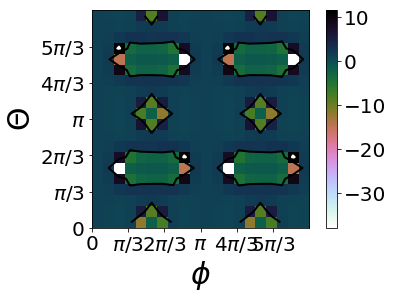

In [27]:
x=y=np.arange(0,2*np.pi,np.pi/10)
X, Y = np.meshgrid(x, y)
point_names = ['0','$\pi/3$','$2\pi$/3', '$\pi$','$4\pi$/3','$5\pi$/3','$2\pi$']
Z = YoungModulus(X,Y,Sij)
im = plt.imshow(Z,cmap=cx2,extent=(0,6,0,6),origin='lower')
cset = plt.contour(Z,np.arange(0,50,10),linewidths=2,cmap=cx1,extent=(0,6,0,6),origin='lower')
pylab.colorbar(im)
#plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=20)
plt.xlabel('$\phi$', fontsize=30)
plt.ylabel('$\Theta$', fontsize=30)
plt.xticks(np.arange(0,6),point_names)
plt.yticks(np.arange(0,6),point_names)
plt.savefig('YoungsModulus.eps')
plt.show()

## Plot of linear compressibility against $\theta$ and $\phi$

-0.312234048904


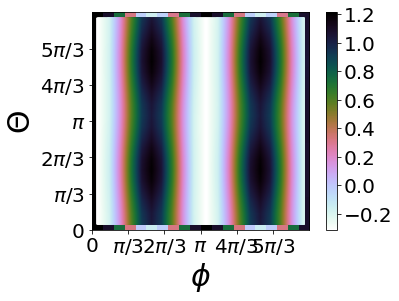

In [28]:
x=y=np.arange(0,2*np.pi,np.pi/10)
X, Y = np.meshgrid(x, y)
Z = linearCompressibility(X,Y,Sij)
print (np.amin(Z))
im = plt.imshow(Z,cmap=cx2,extent=(0,6,0,6),origin='lower')
cset = plt.contour(Z,np.arange(np.amin(Z),np.amax(Z),0.002),linewidths=2,cmap=cx1,extent=(0,6,0,6),origin='lower')
pylab.colorbar(im)
plt.xlabel('$\phi$', fontsize=30)
plt.ylabel('$\Theta$', fontsize=30)
plt.xticks(np.arange(0,6),point_names)
plt.yticks(np.arange(0,6),point_names)
plt.savefig('LinearCompress.eps')
#plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=20)
plt.show()

## Plot of shear modulus against $\theta$ and $\phi$ at $\theta = \frac{\pi}{2}$

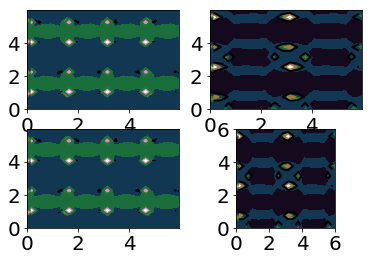

In [29]:
x=y=np.arange(0,2*np.pi,np.pi/10)
i = 0
fig, axs = plt.subplots(2,2)
for ax in axs.ravel():
    X, Y = np.meshgrid(x, y)
    Z = ShearModulus(X,Y,i*np.pi/2,Sij)
    cs = ax.contourf(X, Y, Z, cmap=cx2, origin='lower')
    im = plt.imshow(Z,cmap=cx2,extent=(0,6,0,6),origin='lower')
    cset = ax.contour(Z,np.arange(np.amin(Z),np.amax(Z),10),linewidths=2,cmap=cx2,extent=(0,6,0,6),origin='lower')
    #fig.colorbar(cs, ax=ax, shrink=0.9)
    #ax.set_title("extend = %s" % extend)
    ax.locator_params(nbins=4)
    i = i + 1

#print np.amin(Z)

#pylab.colorbar(im)
#plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=20)
plt.show()